In [2]:
!pip install requests_html
!pip install better_profanity
!pip install spacy
!python3 -m spacy download en_core_web_sm
!pip install gensim

     |████████████████████████████████| 13.6 MB 3.7 MB/s eta 0:00:01


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
import requests
import urllib
import pandas as pd
import numpy as np
from requests_html import HTML
from requests_html import HTMLSession
import re
import matplotlib.pyplot as plt
import seaborn as sns
from better_profanity import profanity
import pickle

In [4]:
import nltk
from nltk.tokenize import WordPunctTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/annielarkins/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
import spacy
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

In [8]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [9]:
import gensim
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS

In [10]:
def get_source(url):
    """Return the source code for the provided URL. 

    Args: 
        url (string): URL of the page to scrape.

    Returns:
        response (object): HTTP response object from requests_html. 
    """

    try:
        session = HTMLSession()
        response = session.get(url)
        return response

    except requests.exceptions.RequestException as e:
        print(e)

In [12]:
def get_results(query):
    
    query = urllib.parse.quote_plus(query)
    response = get_source("https://www.google.co.uk/search?q=" + query)
    
    return response

In [13]:
def parse_results(response):

    output = []
    
    # First id's to try
    css_identifier_first_res = ".xaAUmb"
    css_identifier_lyric_text = ".ujudUb"
    first_result = response.html.find(css_identifier_first_res)
    
    # Second id's to try
    if len(first_result) == 0:
        css_identifier_first_res = ".PZPZlf"
        first_result = response.html.find(css_identifier_first_res)  
    
    for result in first_result:
        lyric_blocks = result.find(css_identifier_lyric_text)
        for block in lyric_blocks:
            output += block.text.split()
        
    return output

In [14]:
def google_search(query):
    response = get_results(query)
    return parse_results(response)

In [15]:
results = google_search("party rock anthem lyrics")
results[0:10]

['Party', 'Rock', 'Yeah', 'Woo', "Let's", 'go', 'Party', 'rock', 'is', 'in']

In [16]:
# Get the lyrics for all the songs
def google_lyrics(playlist):
    lyrics = {}
    songs_wo_result = 0
    for index, track in playlist.iterrows():
        
        search_query = track['Track Name'].split('-')[0] + " " + track['Artist Name(s)'].split(',')[0] + " lyrics"
        lyric_text = google_search(search_query)
        if len(lyric_text) == 0:
            print(search_query)
            songs_wo_result += 1
        else:
            lyrics[track['Track Name']] = lyric_text #np.unique(lyric_text)
    print("Songs with no google result:", songs_wo_result)
    return lyrics

In [17]:
def clean_text(all_words):
    # Clean punctuation
    clean_token=[]
    for token in all_words:
        token = token.lower()
        # remove any value that are not alphabetical
        new_token = re.sub(r'[^a-zA-Z]+', '', token) 
        # remove empty value and single character value
        if new_token != "" and len(new_token) >= 2: 
            vowels=len([v for v in new_token if v in "aeiou"])
            if vowels != 0: # remove line that only contains consonants
                clean_token.append(new_token)

    # Remove stop words
    
    # NLTK
    # Get the list of stop words
    stop_words = stopwords.words('english')
    stop_words.extend(stopwords.words('spanish'))
    # add new stopwords to the list
    stop_words.extend(["could","though","would","also","many",'much'])
    # add more stopwords based on initial findings
    stop_words.extend(["im", "youre", "like"])
    # Remove the stopwords from the list of tokens
    tokens_n = [x for x in clean_token if x not in stop_words]
    
    # Spacy
    tokens_s = [word for word in tokens_n if word.lower() not in sw_spacy]
    
    # Sklearn
    tokens_sk = [word for word in tokens_s if word.lower() not in ENGLISH_STOP_WORDS]
    
    # Gensim
    tokens_g = remove_stopwords(" ".join(tokens_sk)).split()

    # Filter out words that are three letters or less
    tokens = [x for x in tokens_g if len(x) > 3]

    # TODO More filtering

    print("Original Dictionary Size:", len(all_words))
    print("After Punctuation Cleaning Size:", len(clean_token))
    print("After NLTK Stop Word Removal Size:", len(tokens_n))
    print("After Spacy Stop Word Removal Size:", len(tokens_s))
    print("After Sklearn Stop Word Removal Size:", len(tokens_sk))
    print("After Gensim Stop Word Removal Size:", len(tokens_g))
    print("After Removing len <= 3 Words:", len(tokens))
    
    return tokens

In [18]:
def edit_profanity(bad_word):
    cleaned_word = profanity.censor(bad_word)
    if cleaned_word != bad_word:
        cleaned_word = bad_word[0] + ("*" * (len(bad_word) - 1))
    return cleaned_word

In [19]:
def calc_freq(tokens):
    # Count unique words in the list of all words 
    values, counts = np.unique(tokens, return_counts=True)

    # Convert to a dataframe so I can see things better
    df = pd.DataFrame(list(zip(values, counts)),
                   columns =['Word', 'Count'])
    df = df.sort_values(by='Count', ascending=False)

    # Clean up profanity
    df['Word'] = df['Word'].apply(edit_profanity)
    df.to_csv('commonwords.csv')
    df.index = df['Word']
    return df

In [20]:
# Let's graph it!
def graph_counts(df):
    sns.set(font_scale = 2)
    plt.style.use("seaborn-pastel")
    plt.style.use("dark_background")

    plt.figure(figsize=[20,12])
    fig = df.head(25)['Count'].plot.bar(color='red')
    fig.set_xlabel('Word', fontdict= { 'fontsize': 18, 'fontweight':'bold'})
    fig.set_ylabel('Count', fontdict= { 'fontsize': 18, 'fontweight':'bold'})
    fig.set_title("Most Common Words in Spotify's All Out 50's Playlist", fontdict= { 'fontsize': 24, 'fontweight':'bold'})
    plt.show()
    figp = fig.get_figure()
    figp.savefig("topWords50s.png")

In [21]:
def analyze_playlist(playlist_df, extra_words=None):
    lyrics = google_lyrics(playlist_df)
    # Merge all the keys into one long list
    all_words = [item for sublist in lyrics.values() for item in sublist]
    if extra_words is not None:
        all_words.extend(extra_words)
    tokens = clean_text(all_words)
    count_df = calc_freq(tokens)
    graph_counts(count_df)

Dream A Little Dream Of Me Ella Fitzgerald lyrics
Born Too Late The Poni-Tails lyrics
Sh The Crew Cuts lyrics
Everyday Buddy Holly lyrics
You Belong To Me Jo Stafford lyrics
Personality Lloyd Price lyrics
Let The Good Times Roll Shirley & Lee lyrics
My Funny Valentine Chet Baker lyrics
Mack the Knife Bobby Darin lyrics
Black Coffee Sarah Vaughan lyrics
Shout, Pts. 1 & 2 The Isley Brothers lyrics
I'm Old Fashioned  John Coltrane lyrics
Wake up Little Susie The Everly Brothers lyrics
Peggy Sue Buddy Holly lyrics
Jambalaya (On The Bayou) Hank Williams lyrics
Blueberry Hill Fats Domino lyrics
Songs with no google result: 16
Original Dictionary Size: 25114
After Punctuation Cleaning Size: 22827
After NLTK Stop Word Removal Size: 13166
After Spacy Stop Word Removal Size: 11307
After Sklearn Stop Word Removal Size: 11178
After Gensim Stop Word Removal Size: 11178
After Removing len <= 3 Words: 9391


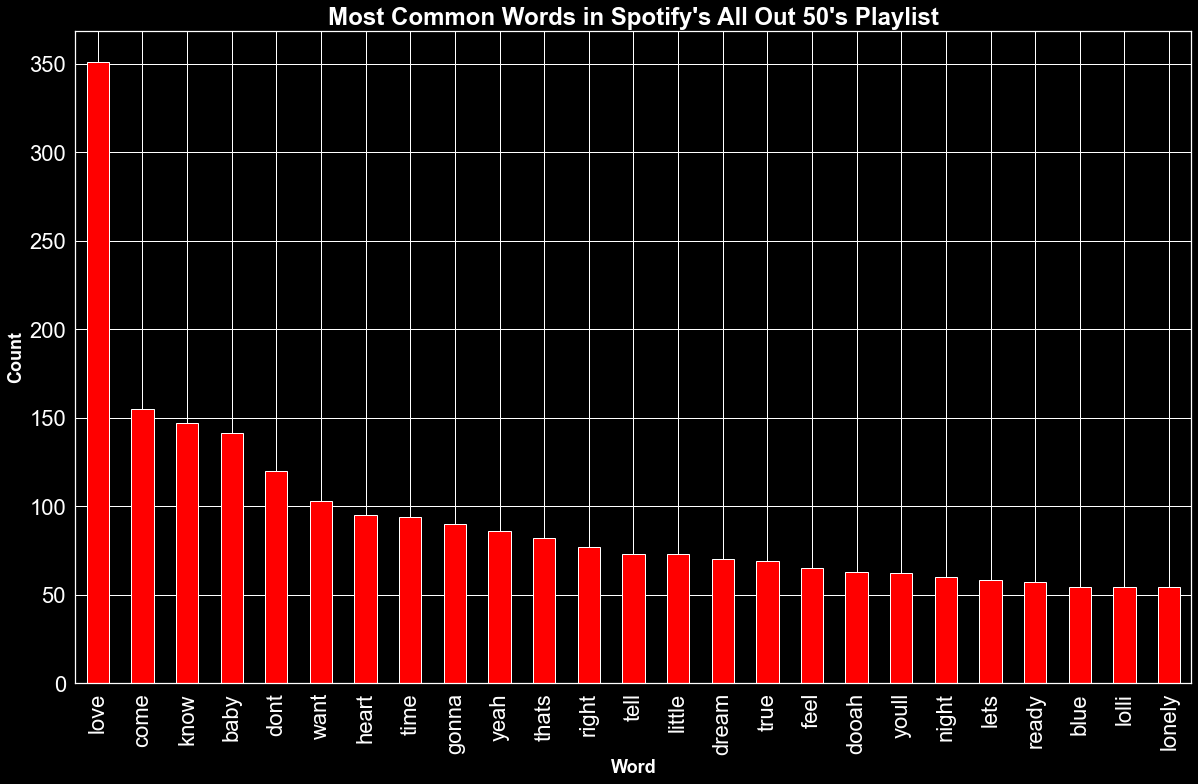

In [21]:
current_playlist = pd.read_csv('all_out_50s.csv')
analyze_playlist(current_playlist)

Your Heart Joyner Lucas lyrics
Songs with no google result: 1
Original Dictionary Size: 22160
After Punctuation Cleaning Size: 19999
After NLTK Stop Word Removal Size: 10921
After Spacy Stop Word Removal Size: 9538
After Sklearn Stop Word Removal Size: 9402
After Gensim Stop Word Removal Size: 9402
After Removing len <= 3 Words: 8080


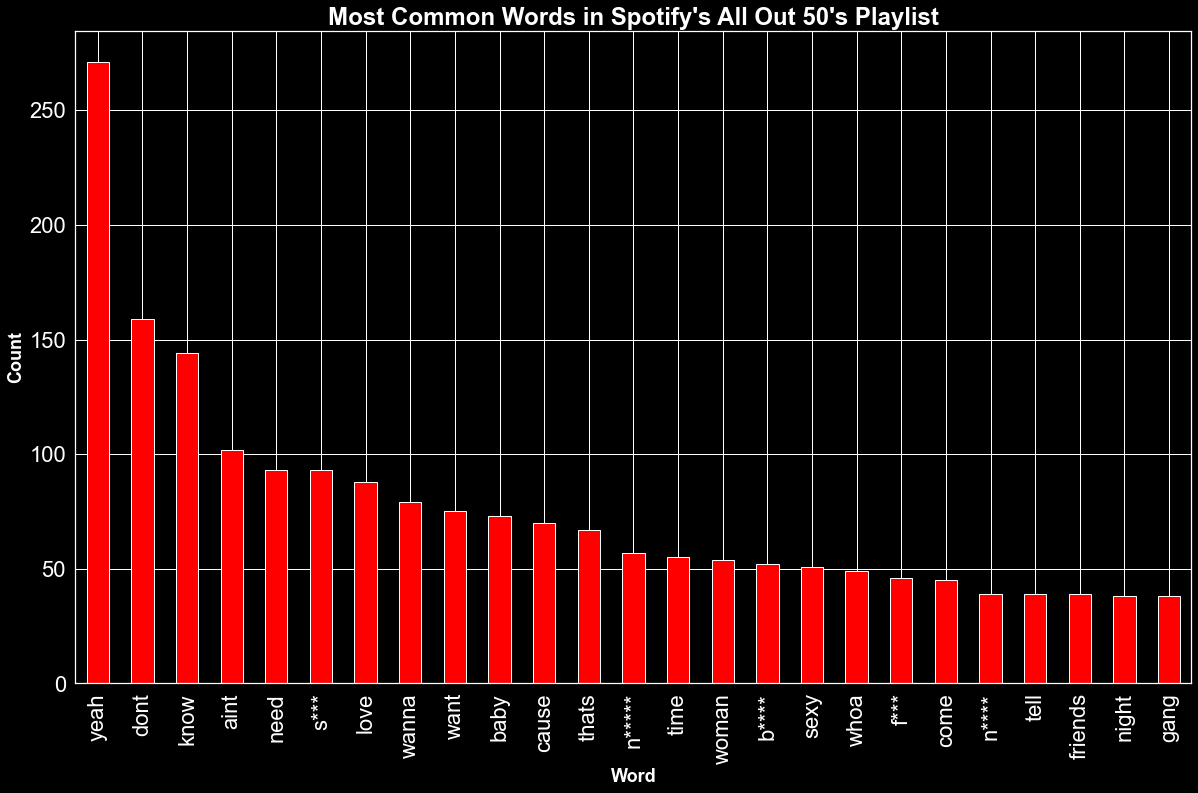

In [22]:
# Load in my playlist data
top_usa = pd.read_csv('top_songs_usa.csv')
my_file = open("extra_lyrics.txt", "r")
content = my_file.read()
extra_words = content.split()
my_file.close()

# Process
analyze_playlist(top_usa)

In [ ]:
top_usa = pd.read_csv('top_songs_usa.csv')
my_file = open("extra_lyrics.txt", "r")
content = my_file.read()
extra_words = content.split()
my_file.close()

lyrics = google_lyrics(top_usa)
# Merge all the keys into one long list
all_words = [item for sublist in lyrics.values() for item in sublist]
if extra_words is not None:
    all_words.extend(extra_words)
tokens = clean_text(all_words)
count_df = calc_freq(tokens)
graph_counts(count_df)

In [ ]:
graph_counts(count_df)

In [ ]:
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
# Which decade has the most "unique" song lyrics?

# Load in all the data
playlist50s = pd.read_csv('all_out_50s.csv')
playlist60s = pd.read_csv('all_out_60s.csv')
playlist70s = pd.read_csv('all_out_70s.csv')
playlist80s = pd.read_csv('all_out_80s.csv')
playlist90s = pd.read_csv('all_out_90s.csv')
playlist00s = pd.read_csv('all_out_00s.csv')
playlist10s = pd.read_csv('all_out_10s.csv')

decades = [playlist50s, playlist60s, playlist70s, playlist80s, playlist90s, playlist00s, playlist10s]
decade_nums = ['50s', '60s', '70s', '80s', '90s', '00s', '10s']

In [ ]:
# For each playlist, calculate the average unique words per song
for decade_num in decade_nums:
    playlist = pd.read_csv('all_out_' + decade_num + '.csv')
    lyrics = google_lyrics(playlist)
    save_obj(lyrics, 'decade' + decade_num)

In [ ]:
# For each playlist, calculate the average unique words per song
decade_avgs = []
for decade_num in decade_nums:
    lyrics = load_obj('decade' + decade_num)
    # Clean lyrics
    cleaned_lyrics = map(clean_text, lyrics.values())
    # Get unique words
    unique_lyrics = map(np.unique, cleaned_lyrics)
    # Count unique words
    lyric_counts = map(len, unique_lyrics)
    # Calculate the average
    avg = np.mean(list(lyric_counts))
    decade_avgs.append(avg)
    print(avg)

In [ ]:
# Format data
decades_df = pd.DataFrame(list(zip(decade_nums, decade_avgs)),
               columns =['Decade', 'Avg Unique Words Per Song'])
decades_df

In [ ]:
# Graph
sns.set(font_scale = 2)
plt.style.use("seaborn-pastel")
plt.style.use("dark_background")

plt.figure(figsize=[10,10])
decades_df.index = decades_df['Decade']
fig = decades_df['Avg Unique Words Per Song'].plot.bar(color='#1DB954')
fig.set_ylabel('Avg Unique Words Per Song', fontdict= { 'fontsize': 18, 'fontweight':'bold'})
fig.set_xlabel('Decade', fontdict= { 'fontsize': 18, 'fontweight':'bold'})
fig.set_title("Unique Words Per Song Over the Decades", fontdict= { 'fontsize': 24, 'fontweight':'bold'})
plt.show()

figp = fig.get_figure()
figp.savefig("uniqueWordsDecades.png")
    

In [ ]:
# Repeat but for non-unique words
# For each playlist, calculate the average unique words per song
decade_avgs = []
for decade_num in decade_nums:
    lyrics = load_obj('decade' + decade_num)
    # Count unique words
    lyric_counts = map(len, lyrics.values())
    # Calculate the average
    avg = np.mean(list(lyric_counts))
    decade_avgs.append(avg)
    print(avg)

In [ ]:
# Format data
decades_df2 = pd.DataFrame(list(zip(decade_nums, decade_avgs)),
               columns =['Decade', 'Avg Words Per Song'])

In [ ]:
# Graph
sns.set(font_scale = 2)
plt.style.use("seaborn-pastel")
plt.style.use("dark_background")

plt.figure(figsize=[10,10])
decades_df2.index = decades_df['Decade']
fig = decades_df2['Avg Words Per Song'].plot.bar(color='#1DB954')
fig.set_ylabel('Avg Words Per Song', fontdict= { 'fontsize': 18, 'fontweight':'bold'})
fig.set_xlabel('Decade', fontdict= { 'fontsize': 18, 'fontweight':'bold'})
fig.set_title("Average Words Per Song Over the Decades", fontdict= { 'fontsize': 24, 'fontweight':'bold'})
plt.show()

figp = fig.get_figure()
figp.savefig("avgWordsDecades.png")


In [ ]:
# Repeat but for non-unique, cleaned words
# For each playlist, calculate the average unique words per song
decade_avgs = []
for decade_num in decade_nums:
    lyrics = load_obj('decade' + decade_num)
    # Clean lyrics
    cleaned_lyrics = map(clean_text, lyrics.values())
    # Count unique words
    lyric_counts = map(len, cleaned_lyrics)
    # Calculate the average
    avg = np.mean(list(lyric_counts))
    decade_avgs.append(avg)
    print(avg)

In [ ]:
# Format data
decades_df3 = pd.DataFrame(list(zip(decade_nums, decade_avgs)),
               columns =['Decade', 'Avg Cleaned Words Per Song'])

In [ ]:
# Graph
sns.set(font_scale = 2)
plt.style.use("seaborn-pastel")
plt.style.use("dark_background")

plt.figure(figsize=[9,7])
decades_df3.index = decades_df['Decade']
fig = decades_df3['Avg Cleaned Words Per Song'].plot.bar(color='#1DB954')
fig.set_ylabel('Avg Cleaned Words Per Song', fontdict= { 'fontsize': 18, 'fontweight':'bold'})
fig.set_xlabel('Decade', fontdict= { 'fontsize': 18, 'fontweight':'bold'})
fig.set_title("Average Non-Stop Words Per Song Over the Decades", fontdict= { 'fontsize': 24, 'fontweight':'bold'})
plt.show()
